<a href="https://colab.research.google.com/github/fariszahid002/CSC3632_Practical1/blob/main/ComputerVisionAI.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Part 3: Computer Vision and Artificial Intelligence Coursework

Main tasks: Implement a Convolutional Neural Network (CNN) on the CIFAR-10 dataset and solve the following three problems using pytorch.

### Importing Necessary Libraries

In [26]:
import torch
import torchvision
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
import numpy as np
import matplotlib.pyplot as plt

### Set to use GPU (if available)

In [27]:
if torch.cuda.is_available():
    print('Using GPU, device name:', torch.cuda.get_device_name(0))
    device = torch.device('cuda')
else:
    print('No GPU found, using CPU instead.')
    device = torch.device('cpu')

Using GPU, device name: Tesla T4


## Setting Up

### Load CIFAR-10 Dataset

In [28]:
# Define transformations for the dataset
transform = transforms.Compose([
    transforms.ToTensor(),  # Convert to tensor
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))  # Normalize images to [-1, 1]
])

# Download and load the CIFAR-10 dataset
train_dataset = datasets.CIFAR10(root='./data', train=True, download=True, transform=transform)
test_dataset = datasets.CIFAR10(root='./data', train=False, download=True, transform=transform)

# Check the dataset size and classes
train_size = len(train_dataset)
test_size = len(test_dataset)
classes = train_dataset.classes

# Output the details
print(f"Training Dataset Size: {train_size}")
print(f"Test Dataset Size: {test_size}")
print(f"Classes: {classes}")

Files already downloaded and verified
Files already downloaded and verified
Training Dataset Size: 50000
Test Dataset Size: 10000
Classes: ['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']


### Splitting Data into Training, Validation and Test Sets

In [29]:
from torch.utils.data import random_split, DataLoader

# Define the train-validation split
val_split = 5000  # Use 5000 samples for validation
train_split = len(train_dataset) - val_split

train_data, val_data = random_split(train_dataset, [train_split, val_split])

# Create data loaders
batch_size = 128
train_loader = DataLoader(train_data, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_data, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

len(train_data), len(val_data), len(test_dataset)


(45000, 5000, 10000)

### Define the CNN Architecture (Without Batch Normalization)
- 3 Convolutional Layers
- 3 Fully Connected Layers

In [30]:
import torch.nn as nn
import torch.nn.functional as F

class ConvNet(nn.Module):
    def __init__(self, imgHeight, imgWidth, categories):
        super().__init__()
        # Convolutional Layers with MaxPooling in between
        self.conv1 = nn.Conv2d(in_channels=3, out_channels=64, kernel_size=3, padding=1)  # Conv Layer 1
        self.pool1 = nn.MaxPool2d(kernel_size=2, stride=2)  # Pooling Layer 1
        self.dropout1 = nn.Dropout(0.25)

        self.conv2 = nn.Conv2d(in_channels=64, out_channels=128, kernel_size=3, padding=1)  # Conv Layer 2
        self.pool2 = nn.MaxPool2d(kernel_size=2, stride=2)  # Pooling Layer 2
        self.dropout2 = nn.Dropout(0.25)

        self.conv3 = nn.Conv2d(in_channels=128, out_channels=256, kernel_size=3, padding=1)  # Conv Layer 3
        self.pool3 = nn.MaxPool2d(kernel_size=2, stride=2)  # Pooling Layer 3
        self.dropout3 = nn.Dropout(0.25)

        # Fully Connected Layers
        self.fc1 = nn.Linear(256 * (imgHeight // 8) * (imgWidth // 8), 256)  # Fixed input size
        self.dropout_fc1 = nn.Dropout(0.25)
        self.fc2 = nn.Linear(256, 128)
        self.dropout_fc2 = nn.Dropout(0.25)
        self.fc3 = nn.Linear(128, categories)
        self.dropout_fc3 = nn.Dropout(0.25)

    def forward(self, x):
        # Convolutional and Pooling Layers
        x = self.pool1(F.relu(self.conv1(x)))  # Conv1 -> Pool1
        x = self.dropout1(x)
        x = self.pool2(F.relu(self.conv2(x)))  # Conv2 -> Pool2
        x = self.dropout2(x)
        x = self.pool3(F.relu(self.conv3(x)))  # Conv3 -> Pool3
        x = self.dropout3(x)

        # Flatten Layer
        x = torch.flatten(x, 1)  # Flatten all dimensions except batch

        # Fully Connected Layers
        x = F.relu(self.fc1(x))  # FC1
        x = self.dropout_fc1(x)
        x = F.relu(self.fc2(x))  # FC2
        x = self.dropout_fc2(x)
        x = self.fc3(x)  # FC3 (Output Layer)

        return x


# Parameters for CIFAR-10
imgHeight, imgWidth, categories = 32, 32, 10

# Instantiate the Model
model = ConvNet(imgHeight, imgWidth, categories).to(device)
print(model)


ConvNet(
  (conv1): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (pool1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (dropout1): Dropout(p=0.25, inplace=False)
  (conv2): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (pool2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (dropout2): Dropout(p=0.25, inplace=False)
  (conv3): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (pool3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (dropout3): Dropout(p=0.25, inplace=False)
  (fc1): Linear(in_features=4096, out_features=256, bias=True)
  (dropout_fc1): Dropout(p=0.25, inplace=False)
  (fc2): Linear(in_features=256, out_features=128, bias=True)
  (dropout_fc2): Dropout(p=0.25, inplace=False)
  (fc3): Linear(in_features=128, out_features=10, bias=True)
  (dropout_fc3): Dropout(p=0.25, inplace=False)
)


### Testing Initial Performance Before Training

In [31]:
# Define the evaluation function
def evaluate(model, val_loader, loss_fun):
    model.eval()  # Set the model to evaluation mode
    val_loss = 0
    correct = 0
    total = 0

    with torch.no_grad():  # Disable gradient calculations for evaluation
        for inputs, targets in val_loader:
            inputs, targets = inputs.to(device), targets.to(device)
            outputs = model(inputs)
            loss = loss_fun(outputs, targets)

            val_loss += loss.item()
            _, predicted = torch.max(outputs, 1)
            total += targets.size(0)
            correct += (predicted == targets).sum().item()

    val_loss /= len(val_loader)
    val_acc = correct / total
    return {'val_loss': val_loss, 'val_acc': val_acc}

# Instantiate the model
model = ConvNet(imgHeight=32, imgWidth=32, categories=10).to(device)

# Define loss function (criterion)
loss_fun = nn.CrossEntropyLoss()

# Evaluate the model on the validation set
initial_eval = evaluate(model, val_loader, loss_fun)
print(f"Initial Validation Loss: {initial_eval['val_loss']:.4f}")
print(f"Initial Validation Accuracy: {initial_eval['val_acc']:.4f}")

Initial Validation Loss: 2.3041
Initial Validation Accuracy: 0.1200


## Question 1: Training Without Batch Normalization

In [32]:
import torch.optim as optim

# Hyperparameters
learning_rate = 0.001
num_epochs = 50
patience = 10  # Early stopping patience
loss_fun = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001, weight_decay=1e-4)


# Function to calculate correct predictions
def correct(output, target):
    pred = output.argmax(dim=1)
    correct_pred = (pred == target).type(torch.float)
    return correct_pred.sum().item()

# Training function with validation monitoring and early stopping
def train_with_validation(train_loader, val_loader, model, loss_fun, optimizer, num_epochs):
    train_loss_history, train_acc_history = [], []
    val_loss_history, val_acc_history = [], []

    # Early stopping variables
    best_val_loss = float('inf')  # Best validation loss starts at infinity
    best_model_state = None       # Best model state
    patience_counter = 0          # Counter for patience

    for epoch in range(num_epochs):
        # Training phase
        model.train()
        total_loss = 0
        total_correct = 0
        total_samples = 0

        for data, target in train_loader:
            data, target = data.to(device), target.to(device)

            # Forward pass
            output = model(data)
            loss = loss_fun(output, target)
            total_loss += loss.item()

            # Calculate correct predictions
            total_correct += correct(output, target)
            total_samples += target.size(0)

            # Backpropagation
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

        # Training metrics
        train_loss = total_loss / len(train_loader)
        train_acc = total_correct / total_samples
        train_loss_history.append(train_loss)
        train_acc_history.append(train_acc)

        # Validation phase
        val_metrics = evaluate(model, val_loader, loss_fun)
        val_loss = val_metrics['val_loss']
        val_acc = val_metrics['val_acc']
        val_loss_history.append(val_loss)
        val_acc_history.append(val_acc)

        # Check if validation loss improved
        if val_loss < best_val_loss:
            best_val_loss = val_loss
            best_model_state = model.state_dict()  # Save the best model state
            patience_counter = 0  # Reset patience counter
            print(f"Validation loss improved to {val_loss:.4f}, saving model...")
        else:
            patience_counter += 1
            print(f"No improvement in validation loss. Patience counter: {patience_counter}/{patience}")

        # Check early stopping condition
        if patience_counter >= patience:
            print("Early stopping triggered.")
            break

        # Print progress
        print(f"Epoch {epoch+1}/{num_epochs}, "
              f"Train Loss: {train_loss:.4f}, Train Accuracy: {train_acc:.4f}, "
              f"Validation Loss: {val_loss:.4f}, Validation Accuracy: {val_acc:.4f}")

    # Save the best model
    if best_model_state is not None:
        torch.save(best_model_state, "best_model.pth")
        print("Best model saved as 'best_model.pth'.")

    return train_loss_history, train_acc_history, val_loss_history, val_acc_history

# Call the training function
train_loss_history, train_acc_history, val_loss_history, val_acc_history = train_with_validation(
    train_loader=train_loader,
    val_loader=val_loader,
    model=model,
    loss_fun=loss_fun,
    optimizer=optimizer,
    num_epochs=num_epochs
)


Validation loss improved to 1.2952, saving model...
Epoch 1/50, Train Loss: 1.6327, Train Accuracy: 0.3972, Validation Loss: 1.2952, Validation Accuracy: 0.5344
Validation loss improved to 1.0438, saving model...
Epoch 2/50, Train Loss: 1.2414, Train Accuracy: 0.5528, Validation Loss: 1.0438, Validation Accuracy: 0.6314
Validation loss improved to 0.9497, saving model...
Epoch 3/50, Train Loss: 1.0556, Train Accuracy: 0.6265, Validation Loss: 0.9497, Validation Accuracy: 0.6696
Validation loss improved to 0.8153, saving model...
Epoch 4/50, Train Loss: 0.9341, Train Accuracy: 0.6723, Validation Loss: 0.8153, Validation Accuracy: 0.7108
Validation loss improved to 0.7511, saving model...
Epoch 5/50, Train Loss: 0.8504, Train Accuracy: 0.7067, Validation Loss: 0.7511, Validation Accuracy: 0.7408
No improvement in validation loss. Patience counter: 1/10
Epoch 6/50, Train Loss: 0.7840, Train Accuracy: 0.7283, Validation Loss: 0.7521, Validation Accuracy: 0.7340
Validation loss improved to 

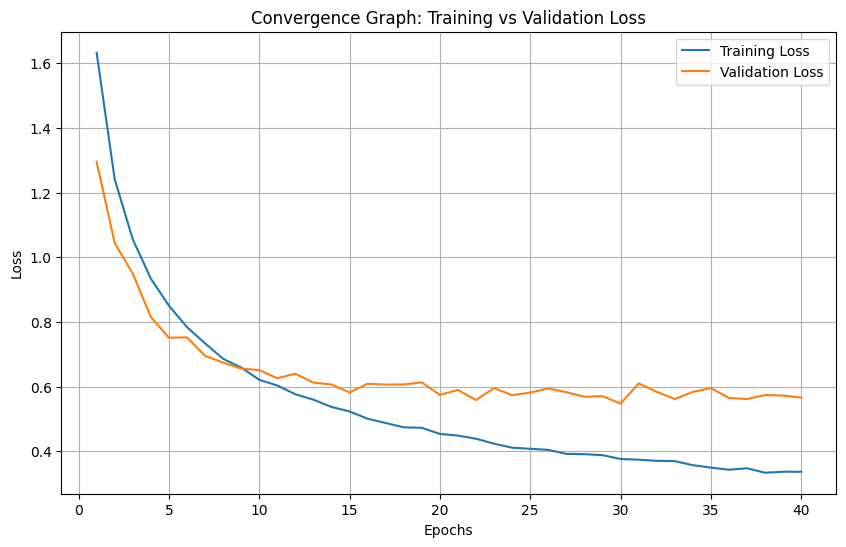

In [33]:
import matplotlib.pyplot as plt

# Generate the convergence graph
plt.figure(figsize=(10, 6))

# Define the epochs range
epochs = range(1, len(train_loss_history) + 1)

# Plot training and validation loss
plt.plot(epochs, train_loss_history, label='Training Loss')
plt.plot(epochs, val_loss_history, label='Validation Loss')

# Add labels, title, and legend
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.title("Convergence Graph: Training vs Validation Loss")
plt.legend()
plt.grid(True)

# Show the graph
plt.show()


## Question 2: CNN Design Architecture (With Batch Normalization)

- 3 Convolutional Layers
- 3 Fully Connected Layers
- 3 Batch Normalization

In [34]:
import torch.nn as nn
import torch.nn.functional as F

class ConvNetWithBatchNorm(nn.Module):
    def __init__(self, imgHeight, imgWidth, categories):
        super().__init__()
        # Convolutional Layers with Batch Normalization and MaxPooling
        self.conv1 = nn.Conv2d(in_channels=3, out_channels=64, kernel_size=3, padding=1)
        self.bn1 = nn.BatchNorm2d(64)  # Batch Normalization after Conv1
        self.pool1 = nn.MaxPool2d(kernel_size=2, stride=2)
        self.dropout1 = nn.Dropout(0.25)

        self.conv2 = nn.Conv2d(in_channels=64, out_channels=128, kernel_size=3, padding=1)
        self.bn2 = nn.BatchNorm2d(128)  # Batch Normalization after Conv2
        self.pool2 = nn.MaxPool2d(kernel_size=2, stride=2)
        self.dropout2 = nn.Dropout(0.25)

        self.conv3 = nn.Conv2d(in_channels=128, out_channels=256, kernel_size=3, padding=1)
        self.bn3 = nn.BatchNorm2d(256)  # Batch Normalization after Conv3
        self.pool3 = nn.MaxPool2d(kernel_size=2, stride=2)
        self.dropout3 = nn.Dropout(0.25)

        # Fully Connected Layers
        self.fc1 = nn.Linear(256 * (imgHeight // 8) * (imgWidth // 8), 256)
        self.dropout_fc1 = nn.Dropout(0.25)
        self.fc2 = nn.Linear(256, 128)
        self.dropout_fc2 = nn.Dropout(0.25)
        self.fc3 = nn.Linear(128, categories)
        self.dropout_fc3 = nn.Dropout(0.25)

    def forward(self, x):
        # Convolutional and Pooling Layers with Batch Normalization
        x = self.pool1(F.relu(self.bn1(self.conv1(x))))  # Conv1 -> BN1 -> Pool1
        x = self.dropout1(x)
        x = self.pool2(F.relu(self.bn2(self.conv2(x))))  # Conv2 -> BN2 -> Pool2
        x = self.dropout2(x)
        x = self.pool3(F.relu(self.bn3(self.conv3(x))))  # Conv3 -> BN3 -> Pool3
        x = self.dropout3(x)

        # Flatten Layer
        x = torch.flatten(x, 1)

        # Fully Connected Layers
        x = F.relu(self.fc1(x))
        x = self.dropout_fc1(x)
        x = F.relu(self.fc2(x))
        x = self.dropout_fc2(x)
        x = self.fc3(x)

        return x

# Parameters for CIFAR-10
imgHeight, imgWidth, categories = 32, 32, 10

# Instantiate the Model
model_with_bn = ConvNetWithBatchNorm(imgHeight, imgWidth, categories).to(device)
print(model_with_bn)

ConvNetWithBatchNorm(
  (conv1): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (pool1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (dropout1): Dropout(p=0.25, inplace=False)
  (conv2): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn2): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (pool2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (dropout2): Dropout(p=0.25, inplace=False)
  (conv3): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (pool3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (dropout3): Dropout(p=0.25, inplace=False)
  (fc1): Linear(in_features=4096, out_features=256, bias=True)
  (dropout_fc1): Dro

### Training with Batch Normalization

In [35]:
import torch.optim as optim

# Hyperparameters
learning_rate = 0.001
num_epochs = 50
loss_fun = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model_with_bn.parameters(), lr=0.001, weight_decay=1e-4)


# Function to calculate correct predictions
def correct(output, target):
    pred = output.argmax(dim=1)
    correct_pred = (pred == target).type(torch.float)
    return correct_pred.sum().item()


# Training function for CNN with batch normalization (without early stopping)
def train_bn(train_loader, val_loader, model, loss_fun, optimizer, num_epochs):
    train_loss_history, train_acc_history = [], []
    val_loss_history, val_acc_history = [], []

    for epoch in range(num_epochs):
        # Training phase
        model.train()
        total_loss = 0
        total_correct = 0
        total_samples = 0

        for data, target in train_loader:
            data, target = data.to(device), target.to(device)

            # Forward pass
            output = model(data)
            loss = loss_fun(output, target)
            total_loss += loss.item()

            # Calculate correct predictions
            total_correct += correct(output, target)
            total_samples += target.size(0)

            # Backpropagation
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

        # Training metrics
        train_loss = total_loss / len(train_loader)
        train_acc = total_correct / total_samples
        train_loss_history.append(train_loss)
        train_acc_history.append(train_acc)

        # Validation phase
        model.eval()
        val_loss = 0
        val_correct = 0
        val_samples = 0

        with torch.no_grad():
            for data, target in val_loader:
                data, target = data.to(device), target.to(device)
                output = model(data)
                loss = loss_fun(output, target)
                val_loss += loss.item()
                val_correct += correct(output, target)
                val_samples += target.size(0)

        val_loss /= len(val_loader)
        val_acc = val_correct / val_samples
        val_loss_history.append(val_loss)
        val_acc_history.append(val_acc)

        # Print progress
        print(f"Epoch {epoch+1}/{num_epochs}, "
              f"Train Loss: {train_loss:.4f}, Train Accuracy: {train_acc:.4f}, "
              f"Validation Loss: {val_loss:.4f}, Validation Accuracy: {val_acc:.4f}")

    return train_loss_history, train_acc_history, val_loss_history, val_acc_history

# Call the training function for CNN with batch normalization
train_loss_bn, train_acc_bn, val_loss_bn, val_acc_bn = train_bn(
    train_loader=train_loader,
    val_loader=val_loader,
    model=model_with_bn,
    loss_fun=loss_fun,
    optimizer=optimizer,
    num_epochs=num_epochs
)


Epoch 1/50, Train Loss: 1.4876, Train Accuracy: 0.4531, Validation Loss: 1.2034, Validation Accuracy: 0.5598
Epoch 2/50, Train Loss: 1.1032, Train Accuracy: 0.6078, Validation Loss: 0.9635, Validation Accuracy: 0.6554
Epoch 3/50, Train Loss: 0.9677, Train Accuracy: 0.6586, Validation Loss: 0.8203, Validation Accuracy: 0.7056
Epoch 4/50, Train Loss: 0.8759, Train Accuracy: 0.6938, Validation Loss: 0.8388, Validation Accuracy: 0.7026
Epoch 5/50, Train Loss: 0.8138, Train Accuracy: 0.7184, Validation Loss: 0.7259, Validation Accuracy: 0.7466
Epoch 6/50, Train Loss: 0.7696, Train Accuracy: 0.7334, Validation Loss: 0.7080, Validation Accuracy: 0.7464
Epoch 7/50, Train Loss: 0.7286, Train Accuracy: 0.7490, Validation Loss: 0.7121, Validation Accuracy: 0.7516
Epoch 8/50, Train Loss: 0.6942, Train Accuracy: 0.7598, Validation Loss: 0.6743, Validation Accuracy: 0.7654
Epoch 9/50, Train Loss: 0.6639, Train Accuracy: 0.7700, Validation Loss: 0.6023, Validation Accuracy: 0.7850
Epoch 10/50, Train 

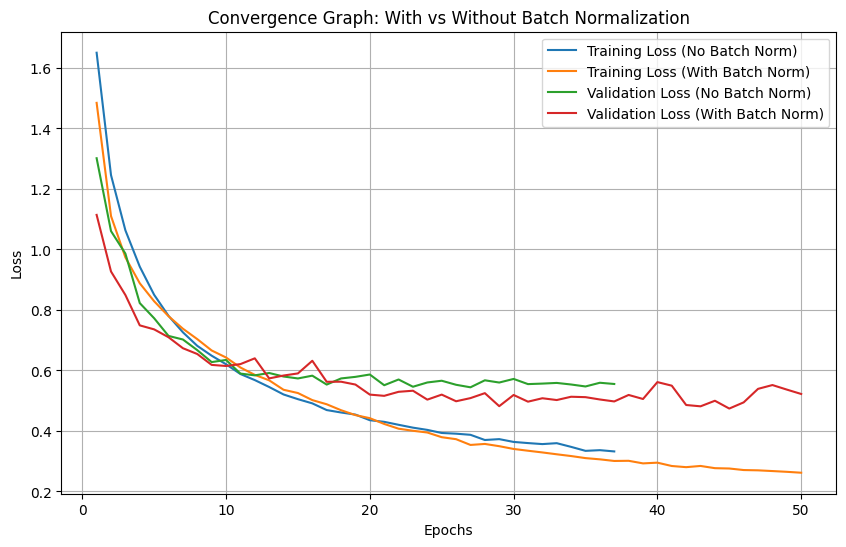

In [16]:
import matplotlib.pyplot as plt

# Generate the convergence graph
plt.figure(figsize=(10, 6))

# Define epochs for both models
epochs_no_bn = range(1, len(train_loss_history) + 1)  # Length of loss history for no BN model
epochs_with_bn = range(1, len(train_loss_bn) + 1)     # Length of loss history for with BN model

# Plot Training Loss Comparison
plt.plot(epochs_no_bn, train_loss_history, label="Training Loss (No Batch Norm)")
plt.plot(epochs_with_bn, train_loss_bn, label="Training Loss (With Batch Norm)")

# Plot Validation Loss Comparison
plt.plot(epochs_no_bn, val_loss_history, label="Validation Loss (No Batch Norm)")
plt.plot(epochs_with_bn, val_loss_bn, label="Validation Loss (With Batch Norm)")

# Add labels, legend, and title
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.title("Convergence Graph: With vs Without Batch Normalization")
plt.legend()
plt.grid(True)

# Show the graph
plt.show()


## 1. For the training, use early stopping and save the model that produces the best validation results. (you will need to use a training set and a validation set) [Marks 10: 5+3+2]

## 2. Show the performance of your designed CNN with and without batch normalisation. Use a convergence graph to show the difference in their performances [Marks 10: 5+5]

## 3. Visualise the Convolutional Features / Filters. This could be done by using imshow or similar methods. Show how filter features change over different layers over a test image. [Marks 20: 10+10]